In [100]:
from kuramoto.SDL_SVP import SDL_SVP
from kuramoto.SDL_BCD import SDL_BCD
from kuramoto.SNMF import SNMF
from kuramoto.LMF import LMF
from kuramoto.nmf import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [6]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


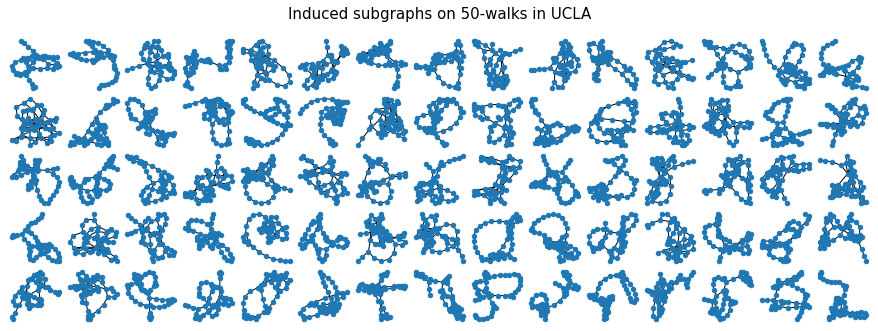

In [7]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [8]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [16]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False


In [164]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.23333333333333334


In [165]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

In [166]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33)

## SNMF

In [167]:
iteration1 = 200 # Iteration for logistic training
xi_list = [0, 0.1, 1, 5, 10] # Trade-off parameters
beta = 1
iter_avg = 4
r = 16

SNMF_AUC_array = np.zeros(shape=[iter_avg, len(xi_list)]) 

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train.T, Y_train.T],
                              X_test=[X_test.T, Y_test.T],
                              n_components=r,
                              xi=xi,
                              L1_reg = [0,0,0],
                              L2_reg = [0,0,0],
                              nonnegativity=[True,True,False],
                              full_dim=False)

        results_dict_new_snmf_cv = SNMF_class_new.train_logistic(iter=iteration1, 
                                                                 subsample_size=None, 
                                                                 beta = beta,
                                                                 search_radius_const=1,
                                                                 update_nuance_param=False,
                                                                 if_compute_recons_error=False, 
                                                                 if_validate=False)

        SNMF_AUC_array[i, j] = results_dict_new_snmf_cv.get('Accuracy')

xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]

initial loading beta [[ 0.46175174 -0.47769919  0.29434192  0.28049791 -0.53283941  0.94235998
  -0.21606913 -0.04645451 -0.34901516 -0.06536046 -0.26578318  0.70510664
   0.23793737 -0.19789413  0.42821307 -0.2940103  -0.66964576]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.43it/s]


initial loading beta [[-0.77330114  0.15329717  0.8097044  -0.65067844  0.27281208  0.14768093
  -0.28066597 -0.35663661 -0.95822871 -0.91914748  0.55140599  0.76254974
  -0.3005423  -0.00733832 -0.13125489  0.6640209  -0.14404735]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.08it/s]


initial loading beta [[ 0.8106358   0.29474639 -0.24667784  0.91898649 -0.92922046  0.61088727
   0.78521633 -0.92371155  0.74131719 -0.25939692 -0.30824389  0.37564987
   0.55276319 -0.93814803  0.21774822  0.58646143 -0.57742773]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.17it/s]


initial loading beta [[ 0.1836608   0.4199212  -0.30819717  0.10139279 -0.86918961  0.26006308
   0.40172112  0.37666271 -0.31834959  0.77754419  0.89415083  0.5034359
  -0.89057641  0.08713962 -0.46578548 -0.09683612 -0.73483639]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 15.84it/s]


initial loading beta [[ 0.9041549   0.73137222 -0.04771919  0.17421128 -0.96100353  0.08259159
   0.18400774  0.13352754  0.15641176 -0.92173318  0.94343056 -0.60426758
  -0.83701969 -0.18764387 -0.45795765  0.14819152 -0.70103648]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 15.61it/s]


initial loading beta [[-0.28912803 -0.59708924 -0.007368    0.99760524  0.60706977 -0.81800061
  -0.45971601  0.03112216  0.32078223  0.36418782  0.4642253  -0.6486932
   0.56388296  0.62491763  0.17742218 -0.88583997 -0.42828362]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.13it/s]


initial loading beta [[ 0.11270169 -0.39137954 -0.3564212  -0.01285474 -0.82625532  0.88807011
  -0.53346055  0.74901082  0.18611661  0.63692765  0.07910704  0.03115003
  -0.38187329  0.27767272 -0.4885421  -0.40905461 -0.11560613]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.12it/s]


initial loading beta [[ 0.53358563  0.95278668  0.24554117  0.93496508 -0.13046984  0.92236747
   0.62036229 -0.21490635  0.04793952 -0.95661299  0.26624145  0.62320071
  -0.15724026 -0.78455278  0.39850756  0.28387862 -0.49580687]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.15it/s]


initial loading beta [[-0.38203811 -0.68156175  0.03819396  0.61521411 -0.48699777 -0.48639014
   0.82166747 -0.3059004   0.18442709 -0.21910277  0.15472766  0.84176152
   0.09071699 -0.36911585 -0.67967636 -0.38322576 -0.40518726]]


100%|█████████████████████████████████████████| 200/200 [00:14<00:00, 14.27it/s]


initial loading beta [[ 0.24985435  0.50388467  0.08569471 -0.69616573 -0.4668377  -0.9947582
   0.72725695 -0.965969    0.07235537 -0.93609308 -0.45130872 -0.0331383
  -0.72565298  0.18323705 -0.93158192 -0.44766464 -0.80569949]]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 17.49it/s]


initial loading beta [[ 0.18995567  0.10900307 -0.52311004  0.82440131 -0.68789958  0.2413252
  -0.1548553   0.96659259 -0.80288389 -0.36113701 -0.62926889 -0.93135736
  -0.53298851 -0.01521173  0.1053431   0.66154198  0.69322116]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.99it/s]


initial loading beta [[ 0.71120866  0.39527545  0.08891127 -0.86596378 -0.67220342 -0.90071282
   0.57843819  0.79383691  0.46175161 -0.05877363  0.55970073 -0.72628427
   0.20557539 -0.35404089 -0.91322697 -0.99307653 -0.53418365]]


100%|█████████████████████████████████████████| 200/200 [00:14<00:00, 13.89it/s]


initial loading beta [[ 0.02960656 -0.70905732  0.15856663 -0.41687033 -0.18741199  0.80501668
   0.11605631 -0.90335818  0.94657731 -0.06883887 -0.3857491   0.76076594
  -0.60658663  0.6673788   0.85317171 -0.99587711 -0.89643043]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 15.75it/s]


initial loading beta [[ 0.5169363  -0.01799956  0.53241738  0.60195286 -0.86002894 -0.13262566
  -0.71868132  0.73865472  0.64891446  0.98292833 -0.4418792  -0.10996612
   0.45840761 -0.22895391 -0.09830099  0.95364801 -0.40077416]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.92it/s]


initial loading beta [[ 0.00138891 -0.34872961 -0.70337575 -0.82605332 -0.16087305 -0.77318283
  -0.86928232  0.49449866 -0.80369975  0.7704672  -0.81235247 -0.19093408
  -0.59642739  0.45222021 -0.15444856 -0.47510693  0.19598935]]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.72it/s]


initial loading beta [[ 0.22985522  0.42830863 -0.36631613 -0.0086284   0.27993645  0.58670222
  -0.98206248 -0.0688574  -0.26500666 -0.8248646   0.67764132 -0.3055015
  -0.16907079  0.06973735 -0.66786998  0.36413945  0.98227325]]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.90it/s]


initial loading beta [[-0.78772193 -0.51727041 -0.99286127  0.09846157 -0.72121257  0.40747223
   0.39998945  0.45992691 -0.26194832 -0.91646571 -0.52490684  0.62931714
   0.97029979 -0.33211839 -0.34116891  0.71749534 -0.2244848 ]]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.74it/s]


initial loading beta [[ 0.32291095  0.81196008 -0.03571514 -0.07174402  0.65372753  0.90395993
   0.03727051 -0.70575256 -0.72455777  0.56723133 -0.81570786 -0.34288362
  -0.57563903  0.20118978  0.99477463 -0.93368024  0.30278131]]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.87it/s]


initial loading beta [[-0.40448403 -0.5932074  -0.13082019 -0.15701569 -0.33609744  0.80060288
   0.89368663 -0.51180292 -0.51079734  0.16656154  0.33551361 -0.58065255
   0.97486534 -0.81404031  0.43625893 -0.7190106  -0.73405744]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 16.56it/s]


initial loading beta [[-0.78911007  0.06710221 -0.76482099  0.15287762 -0.69079369  0.96120858
  -0.11007473 -0.46325618 -0.14491135 -0.86545788  0.50928151  0.63306921
   0.2456542   0.96192649 -0.84156948  0.17232023  0.05418295]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.58it/s]


In [168]:
results_dict_new_snmf_cv

{'xi': 10,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 16,
 'loading': [array([[0.00000000e+00, 5.42069495e-07, 3.12970218e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.44784123e-02, 2.47004924e-02, 2.50028396e-02, ...,
          2.45370776e-02, 2.51002987e-02, 2.46836454e-02],
         [2.51856097e-03, 2.83658004e-03, 2.72664099e-03, ...,
          2.52093397e-03, 2.84061316e-03, 3.02794406e-03],
         ...,
         [4.09149452e-03, 4.11930893e-03, 3.99485509e-03, ...,
          4.05041264e-03, 4.62179119e-03, 4.12080529e-03],
         [2.44779030e-02, 2.47010358e-02, 2.50033237e-02, ...,
          2.45373614e-02, 2.51008235e-02, 2.46819635e-02],
         [0.00000000e+00, 6.43872614e-08, 0.00000000e+00, ...,
          0.00000000e+00, 1.90011837e-07, 0.00000000e+00]]),
  array([[-6.41578233,  0.14561337,  0.13965784,  0.10348265,  0.11993575,
           0.13189213,  0.10587008,  0.11831115,  0

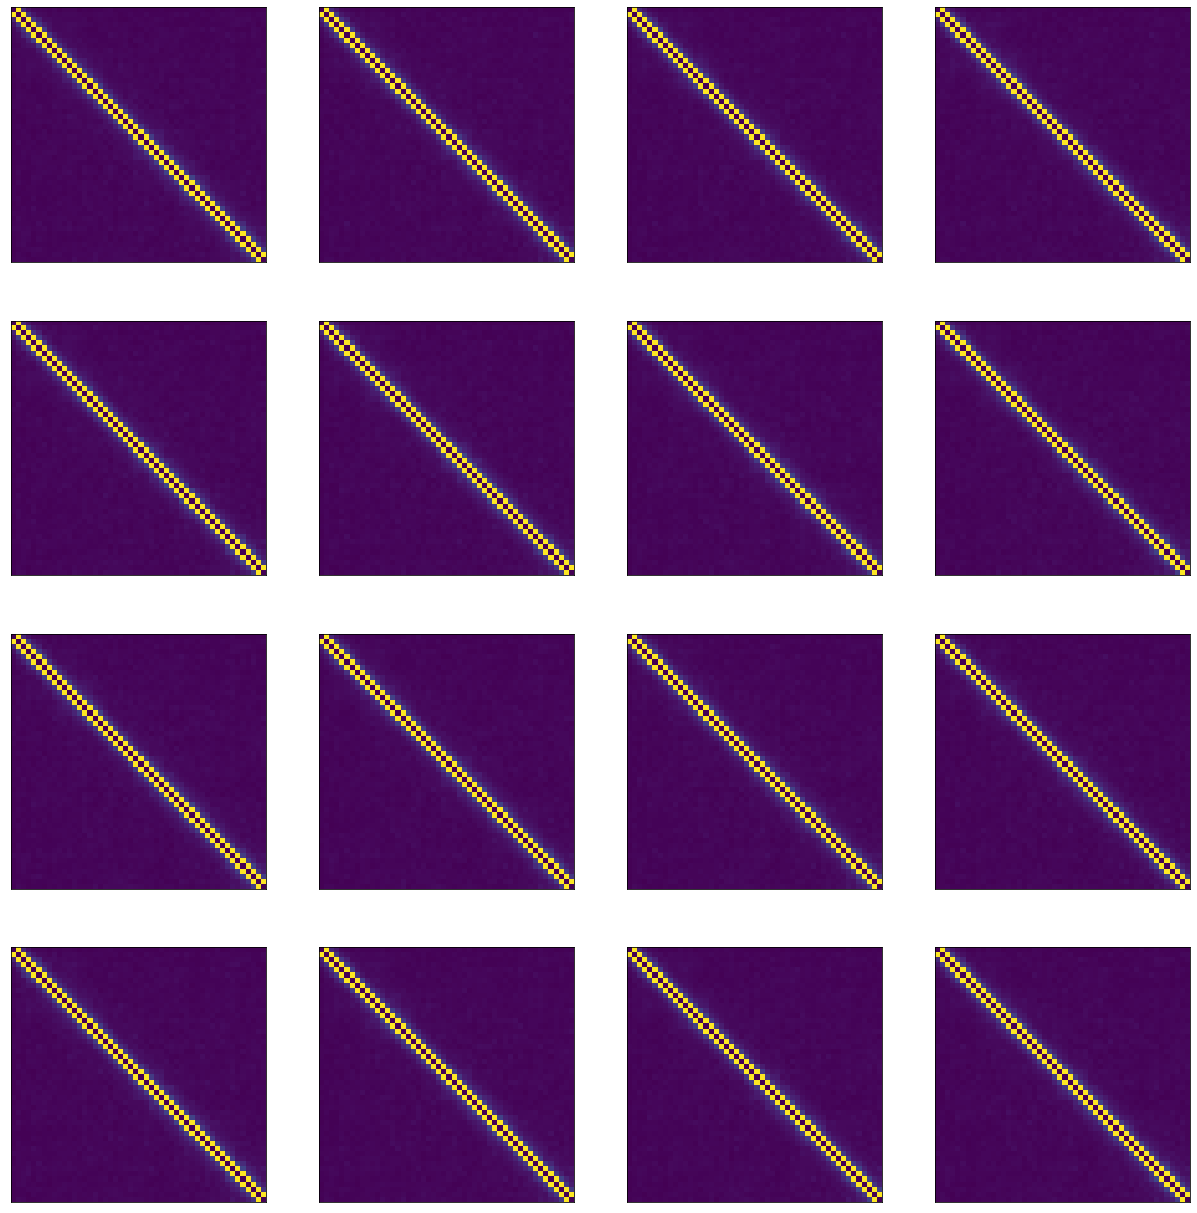

In [169]:
W = results_dict_new_snmf_cv.get('loading')[0]
display_dictionary(save_name=save_folder+'UCLA_SNMF_Dictionaries', W=W, figsize=[20,20])

## LMF

In [170]:
iteration = 200
results_dict_list = []
xi_list = [0, 0.1, 1, 10]
beta_list = [1, None]
iter_avg = 4
r = 16

LMF_AUC_array_naive = np.zeros(shape=[iter_avg, len(xi_list)])
LMF_AUC_array_exhaustive = np.zeros(shape=[iter_avg, len(xi_list)])

for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            LMF_class_new = LMF(X = [X_train.T, Y_train.T],
                            X_test = [X_test.T, Y_test.T],
                            n_components = r,
                            xi = xi,
                            L1_reg = [0,0,0],
                            L2_reg = [0,0,1],
                            nonnegativity=[True,True,False],
                            full_dim=False)

            results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                                    beta = beta, 
                                                    search_radius_const=1000,
                                                    fine_tune_beta=True,
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)

            results_dict_new.update({'method': 'SDL-feat (naive)'})
            results_dict_new.update({'beta': beta})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (naive)')})
            results_dict_new.update({'F_score': results_dict_new.get('F_score (naive)')})
            results_dict_list.append(results_dict_new.copy())

            results_dict_new1 = results_dict_new.copy()
            results_dict_new1.update({'method': 'SDL-feat (exhaustive)'})
            results_dict_new1.update({'beta': beta})
            results_dict_new1.update({'Accuracy': results_dict_new1.get('Accuracy (exhaustive)')})
            results_dict_new1.update({'F_score': results_dict_new.get('F_score (exhaustive)')})
            results_dict_list.append(results_dict_new1.copy())

            LMF_AUC_array_naive[i,j] = results_dict_new.get('Accuracy (naive)') 
            LMF_AUC_array_exhaustive[i,j] = results_dict_new.get('Accuracy (exhaustive)')

initial loading beta [[0.2576834  0.32184566 0.30043204 0.432423   0.95928888 0.85453688
  0.73882566 0.95968054 0.60896239 0.20516072 0.742448   0.78086325
  0.94496006 0.22166751 0.78972277 0.33315127 0.43429712]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 48.21it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.581, 0.64, 0.402]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.55it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.501, 0.697, 0.118]
initial loading beta [[0.5547324  0.82517358 0.53368733 0.28784015 0.18503466 0.86368732
  0.69836283 0.04075751 0.32347122 0.86211851 0.6410295  0.52631059
  0.32665553 0.76283926 0.03349952 0.86874021 0.52318367]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 57.55it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.511, 0.65, 0.316]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.64it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.947, 0.489, 0.747, 0.096]
initial loading beta [[0.14149953 0.68038255 0.78325971 0.03732474 0.5337273  0.16000882
  0.91635059 0.44790756 0.33932253 0.27339079 0.07212542 0.30498866
  0.2570688  0.55997852 0.06322374 0.71906876 0.43051628]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 53.06it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.912, 0.533, 0.66, 0.303]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 30.18it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.51, 0.707, 0.103]
initial loading beta [[0.46761639 0.7132777  0.07536918 0.81787756 0.27710548 0.70597076
  0.41957627 0.63921041 0.63160812 0.52678238 0.46981796 0.75360844
  0.94686889 0.88113354 0.80006834 0.4786376  0.68621905]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 57.94it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.484, 0.623, 0.263]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.68it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.117, 0.487, 0.751, nan]
initial loading beta [[0.00188253 0.00333998 0.24876449 0.48964637 0.95561302 0.12039279
  0.08116944 0.43593376 0.40612104 0.18149597 0.88205723 0.4838235
  0.90825936 0.207799   0.41877315 0.68736977 0.89584707]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 49.96it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.539, 0.596, 0.333]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.40it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.998, 0.463, 0.313, 0.354]
initial loading beta [[0.97128428 0.43192359 0.58340535 0.87980825 0.87215874 0.23385788
  0.08474983 0.09635679 0.07604558 0.49410629 0.52337548 0.82390092
  0.75813848 0.72110473 0.15956588 0.80781149 0.93714821]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 52.80it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.476, 0.67, 0.21]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.12it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.268, 0.526, 0.549, 0.35]
initial loading beta [[0.59402016 0.12435477 0.85449725 0.08150065 0.63909541 0.27404484
  0.37693434 0.30052939 0.73053737 0.45228064 0.04282049 0.84558364
  0.81176678 0.53353914 0.02742183 0.08035495 0.54949787]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.02it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [2.0, 0.437, 0.603, 0.234]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.33it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.486, 0.535, 0.289]
initial loading beta [[0.79930475 0.47118209 0.1468386  0.46579523 0.73318841 0.58395682
  0.80637104 0.51354308 0.76391877 0.10373408 0.74544953 0.59499669
  0.89933181 0.78369449 0.37516971 0.13192895 0.89105085]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.30it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.365, 0.502, 0.633, 0.306]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.36it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.489, 0.488, 0.262]
initial loading beta [[9.36604584e-01 8.13093037e-01 2.76616271e-01 3.70688693e-02
  1.52965091e-01 1.13864703e-01 3.86146101e-01 3.80554123e-01
  4.78987536e-01 3.70579433e-01 7.93424747e-01 8.37519791e-02
  3.16300606e-01 2.68534225e-01 2.11597432e-01 4.25749817e-02
  9.11099006e-04]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 34.92it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.426, 0.525, 0.269]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.27it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.417, 0.515, 0.258]
initial loading beta [[0.42065368 0.23129634 0.97145796 0.0523866  0.9808136  0.96368881
  0.21814688 0.57217696 0.68537172 0.55921657 0.75928137 0.84271504
  0.81757141 0.18191523 0.2924813  0.65027089 0.55407825]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 34.94it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.469, 0.556, 0.275]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.33it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.476, 0.572, 0.191]
initial loading beta [[0.63333948 0.82682704 0.50983644 0.01681623 0.0339233  0.65318884
  0.7215579  0.82736294 0.7360572  0.30761502 0.04509116 0.28122881
  0.71253233 0.9556669  0.05291516 0.874933   0.76156564]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.78it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.481, 0.606, 0.255]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.33it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.506, 0.519, 0.341]
initial loading beta [[0.4036586  0.03730589 0.47427307 0.26898309 0.5749766  0.21462943
  0.48559032 0.09347247 0.14684275 0.1409113  0.08650957 0.82149464
  0.10054388 0.64421383 0.95132589 0.40668836 0.08184742]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.66it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.9, 0.469, 0.646, 0.276]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.95it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.999, 0.488, 0.458, 0.332]
initial loading beta [[0.43929608 0.92145803 0.74361646 0.9763782  0.46068703 0.63936979
  0.13244941 0.16649367 0.09636266 0.20679479 0.15377119 0.73823373
  0.01164452 0.3864362  0.96695845 0.35724308 0.26174372]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.62it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.102, 0.568, 0.572, 0.386]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.96it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.576, 0.717, 0.125]
initial loading beta [[0.67101765 0.22499768 0.57737907 0.9807269  0.17799232 0.1355546
  0.04607383 0.62547555 0.30960333 0.36818821 0.73827582 0.37481344
  0.06622822 0.0576745  0.36870319 0.44061543 0.08025316]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 45.55it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.054, 0.511, 0.589, 0.256]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.19it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.527, 0.684, 0.13]
initial loading beta [[0.98339888 0.46047087 0.68900908 0.23609512 0.77813955 0.0180251
  0.52907635 0.4143598  0.94282832 0.82263749 0.40059137 0.37899451
  0.11681733 0.65068883 0.24595348 0.73524638 0.76407391]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.69it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.039, 0.493, 0.646, 0.255]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.08it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.501, 0.687, 0.131]
initial loading beta [[0.28777821 0.5701387  0.89761782 0.79237283 0.14805583 0.85359843
  0.45535925 0.64055013 0.80401359 0.79227524 0.12180886 0.39576792
  0.66687962 0.86050707 0.09681625 0.40749066 0.01728888]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 36.95it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.077, 0.53, 0.609, 0.247]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.82it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.584, 0.737, 0.114]
initial loading beta [[0.00775657 0.05827597 0.72684723 0.95016084 0.02420614 0.45421362
  0.82012513 0.00939284 0.17491741 0.03081664 0.42774652 0.44990624
  0.55800182 0.60101135 0.93670694 0.72277042 0.97283109]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 67.11it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.452, 0.542, 0.277]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.09it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.009, 0.541, 0.741, 0.025]
initial loading beta [[0.94549573 0.34960222 0.8623646  0.92423016 0.22358843 0.84096598
  0.23401149 0.9975437  0.92062455 0.68797624 0.23568161 0.0076252
  0.9265439  0.13218156 0.59354165 0.6290098  0.28832051]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.12it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.516, 0.552, 0.37]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.52it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.002, 0.47, 0.714, 0.066]
initial loading beta [[0.54789318 0.19547558 0.16325529 0.85725449 0.55771805 0.45959679
  0.32544849 0.86871126 0.69682048 0.19450538 0.42499184 0.00945138
  0.21361104 0.28844575 0.4384535  0.89631636 0.63009955]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.52it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.766, 0.489, 0.596, 0.294]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.74it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.004, 0.516, 0.747, 0.051]
initial loading beta [[0.09158125 0.68180347 0.60556437 0.95280297 0.24880674 0.15581567
  0.51214248 0.23892566 0.43084573 0.35417398 0.27935091 0.97326138
  0.12575533 0.43059547 0.54600934 0.36446303 0.84923804]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 67.30it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.986, 0.541, 0.62, 0.315]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.99it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.524, 0.707, 0.139]
initial loading beta [[0.58876319 0.18736146 0.27864517 0.23063742 0.78287312 0.22130928
  0.93348149 0.55994294 0.98104113 0.20374361 0.20471749 0.75203789
  0.00366083 0.84205224 0.32166915 0.44493486 0.46855381]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 60.27it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.573, 0.507, 0.609, 0.301]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.16it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.522, 0.498, 0.349]
initial loading beta [[0.62442443 0.40882082 0.78742721 0.29681919 0.33892447 0.24911906
  0.25551882 0.58727427 0.27753137 0.84015179 0.82560942 0.78672963
  0.9322637  0.99067721 0.73678523 0.34939671 0.08341927]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 55.35it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.663, 0.512, 0.572, 0.342]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.88it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.694, 0.526, 0.391, 0.351]
initial loading beta [[0.3688628  0.0777995  0.51046132 0.06517377 0.91807993 0.79694512
  0.32837786 0.19493215 0.23856576 0.72043247 0.82861408 0.99794924
  0.39960502 0.48480528 0.93035487 0.40210762 0.05397102]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.32it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.732, 0.491, 0.653, 0.259]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.05it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.988, 0.54, 0.465, 0.351]
initial loading beta [[0.05919135 0.41786901 0.16899173 0.30048968 0.47073256 0.53093581
  0.81964138 0.58372963 0.23075699 0.32201232 0.38637112 0.45771209
  0.36410624 0.1616678  0.26958963 0.52814217 0.90160714]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.57it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.013, 0.43, 0.606, 0.204]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.32it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.996, 0.516, 0.525, 0.344]
initial loading beta [[0.18532491 0.78581303 0.15041164 0.17466705 0.033154   0.26868627
  0.27278112 0.67604795 0.86574859 0.32696231 0.40860442 0.25297266
  0.64798077 0.4999729  0.79109    0.50410035 0.9411001 ]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 41.73it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.004, 0.519, 0.532, 0.347]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.04it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.988, 0.531, 0.589, 0.344]
initial loading beta [[0.22981343 0.72722199 0.38173212 0.79215193 0.83941605 0.69533603
  0.82149405 0.89949045 0.96495921 0.81334876 0.13947275 0.41122282
  0.55284224 0.52960468 0.05838862 0.24896522 0.06250063]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 35.79it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.518, 0.657, 0.301]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.19it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.381, 0.572, 0.64, 0.382]
initial loading beta [[0.54065937 0.89572709 0.54498009 0.2731583  0.95187382 0.17521735
  0.01416684 0.34927937 0.41446196 0.95931763 0.02591585 0.41414683
  0.239147   0.46196899 0.65807581 0.84247989 0.11153304]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 35.24it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.169, 0.47, 0.593, 0.309]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.94it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.488, 0.63, 0.286]
initial loading beta [[0.55405041 0.31941328 0.8634258  0.32946823 0.13098942 0.88054809
  0.17708145 0.19314691 0.78382989 0.83763783 0.33126825 0.0527094
  0.18638369 0.64301457 0.45425587 0.91240213 0.8868122 ]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 35.58it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.447, 0.596, 0.231]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.79it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.827, 0.479, 0.606, 0.273]
initial loading beta [[0.74701932 0.15301038 0.66905165 0.02776599 0.8292649  0.52250233
  0.92076969 0.04740005 0.42372319 0.31775354 0.45934314 0.83194693
  0.09402679 0.18779481 0.13662745 0.3308265  0.45383564]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 49.75it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.103, 0.539, 0.576, 0.337]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.69it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.584, 0.724, 0.128]
initial loading beta [[0.70846059 0.60006501 0.88410873 0.55040064 0.10892117 0.37611568
  0.03848085 0.5339066  0.86665228 0.09464293 0.01157989 0.38711103
  0.69852913 0.09772845 0.79350799 0.833907   0.18049596]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.86it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.035, 0.488, 0.566, 0.263]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.94it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [2.0, 0.5, 0.673, 0.185]
initial loading beta [[2.84548129e-01 4.74241272e-01 2.25512748e-04 6.97336149e-01
  8.91768958e-01 1.31834773e-02 8.69140290e-01 7.39886361e-01
  6.46312150e-01 1.58866772e-01 5.82531576e-01 1.17046152e-01
  7.36514547e-01 3.00816568e-01 7.27027948e-01 6.32367509e-01
  3.92331605e-01]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.72it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.142, 0.51, 0.566, 0.303]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.06it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.507, 0.721, 0.144]
initial loading beta [[0.91959924 0.40270373 0.6913632  0.89542351 0.43648935 0.2119323
  0.69123454 0.8786623  0.88239287 0.31124911 0.15285787 0.74131858
  0.61889244 0.04210491 0.99408548 0.88254517 0.2628059 ]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.90it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.074, 0.517, 0.495, 0.353]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.92it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.542, 0.731, 0.216]


In [171]:
print(np.sum(LMF_AUC_array_naive, 0))        
xi_NMF_n = xi_list[np.argmax(np.sum(LMF_AUC_array_naive, 0))]
print(xi_NMF_n)

print(np.sum(LMF_AUC_array_exhaustive, 0))        
xi_NMF_e = xi_list[np.argmax(np.sum(LMF_AUC_array_exhaustive, 0))]
print(xi_NMF_e)

[2.30976431 2.44107744 2.37710438 2.2020202 ]
0.1
[2.90909091 1.87878788 2.46464646 2.84848485]
0


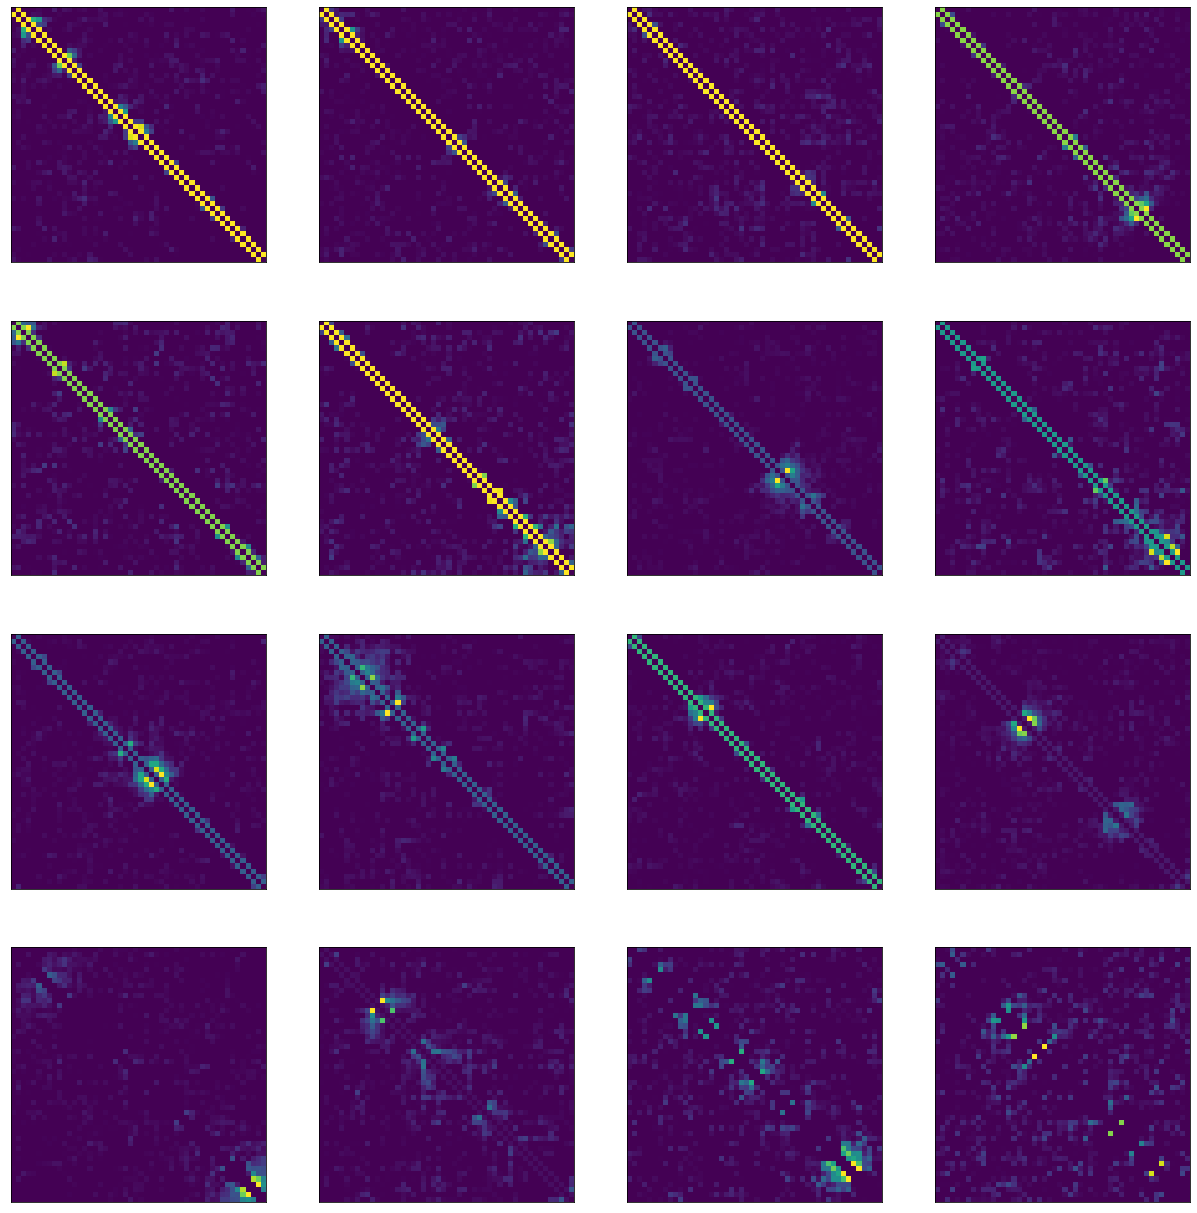

In [172]:
W = results_dict_new.get('loading')[0]
display_dictionary(save_name=save_folder+'UCLA_LMF_Dictionaries', W=W, figsize=[20,20])